In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression


In [238]:
#LOAD THE DATASET
df = pd.read_excel(r'Market Pricing (Feb 2023 - Nov 2024).xlsx', index_col='Timestamp', parse_dates=True)
df = df.apply(pd.to_numeric)
df.head(5)

,Supply Period,Correct Hour,Hour,Minimum,Maximum,Average
Timestamp,,,,,,
2023-02-26 00:00:00,1680220800000000000,0,1,4.509053,7.657594,5.686146
2023-02-26 01:00:00,1680220800000000000,1,2,3.708706,5.417432,4.225251
2023-02-26 02:00:00,1680220800000000000,2,3,3.981605,6.046616,4.355636
2023-02-26 03:00:00,1680220800000000000,3,4,4.022465,6.047146,4.493957
2023-02-26 04:00:00,1680220800000000000,4,5,3.621861,6.165480,4.542590


In [239]:
# Exploratory Data Analysis (EDA)
print("Dataset Summary:")
print(df[['Minimum', 'Maximum', 'Average']].describe())

Dataset Summary:
            Minimum       Maximum       Average
count  14880.000000  14880.000000  14880.000000
mean       3.079151      7.072934      4.574846
std        2.521912      8.874984      3.653212
min      -30.412698    -11.741057    -24.430888
25%        2.207312      3.265020      2.802622
50%        2.912964      4.194471      3.645847
75%        3.793671      7.500163      4.969665
max       27.953235    315.687285     99.865904


In [240]:
print("\nDataset Info:")
print(df.info())
print(df.shape)


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14880 entries, 2023-02-26 00:00:00 to 2024-11-06 23:00:00
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Supply Period  14880 non-null  int64  
 1   Correct Hour   14880 non-null  int64  
 2   Hour           14880 non-null  int64  
 3   Minimum        14880 non-null  float64
 4   Maximum        14880 non-null  float64
 5   Average        14880 non-null  float64
dtypes: float64(3), int64(3)
memory usage: 813.8 KB
None
(14880, 6)


The time series dataset does not contain any null values.

**Plotting the Average Price of Time Series**
- The electricity market prices in 1 hour interval shows a very volatile movement and short term extreme movements in the prices.

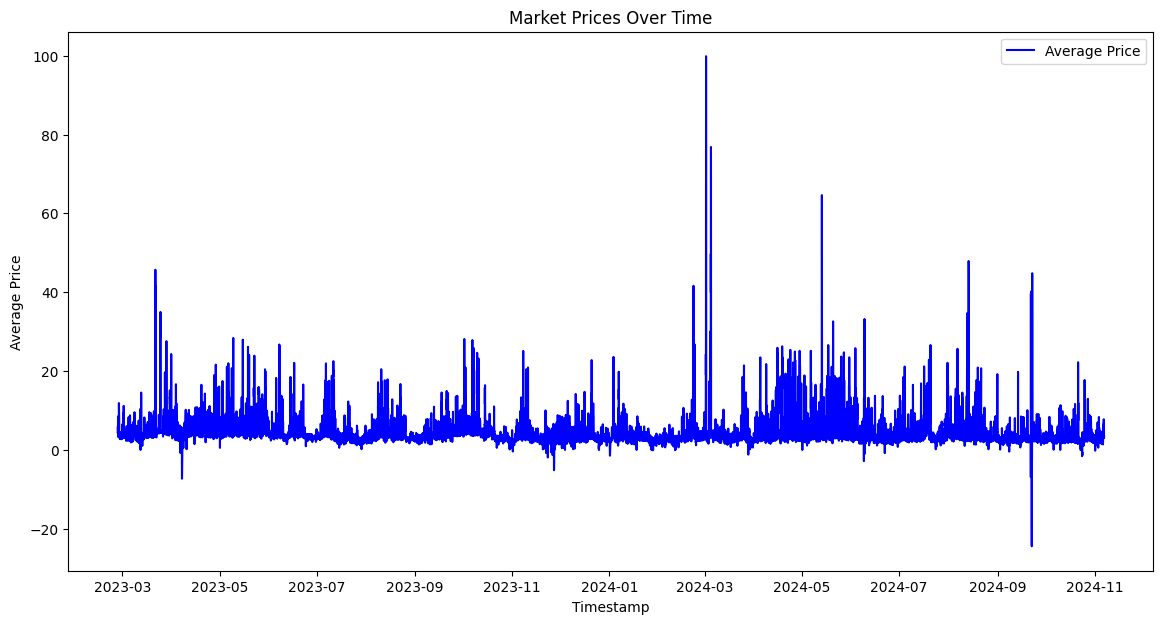

In [241]:
# Trend Analysis
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Average'], label='Average Price', color='blue')
plt.title('Market Prices Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Average Price')
plt.legend()
plt.show()


**AVERAGE PRICE DISTRIBUTION**
- The average price distribution is heavily skewed to the right, with most values concentrated near zero.
- There are some notable outliers, including a maximum price of 99 and a sharp drop to -24.
- Negative average prices are rare but significant, suggesting instances of surplus energy or unique market conditions.

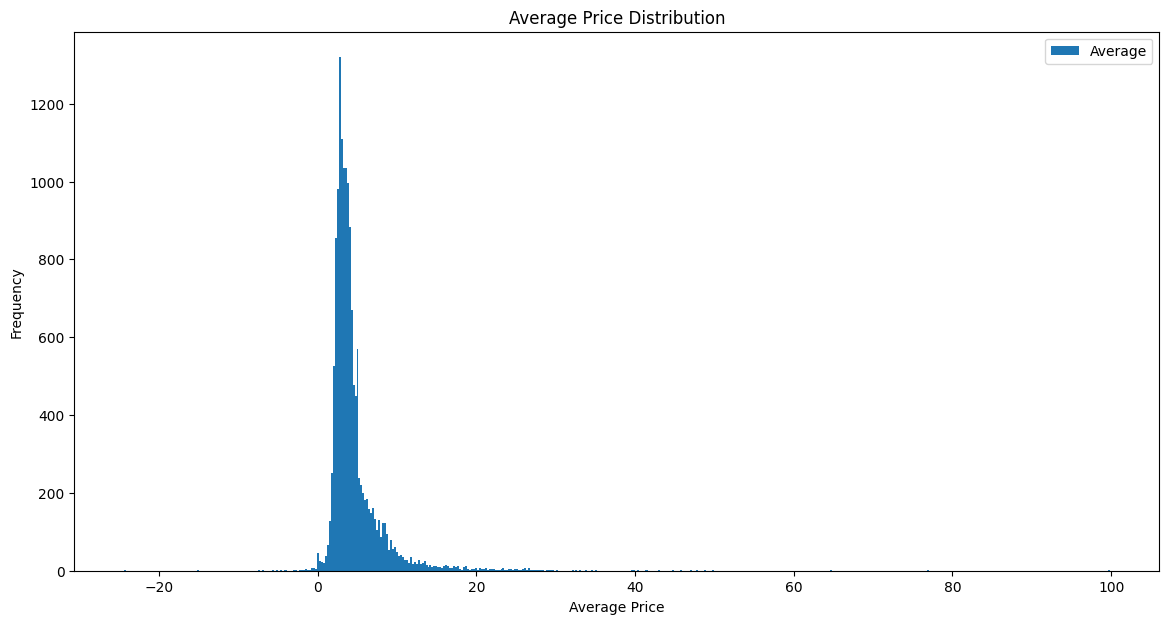

In [242]:
plt.figure(figsize=(14, 7))
df['Average'].plot(kind='hist', bins=500)
plt.title('Average Price Distribution')
plt.xlabel('Average Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Text(0.5, 0, 'Year Month')

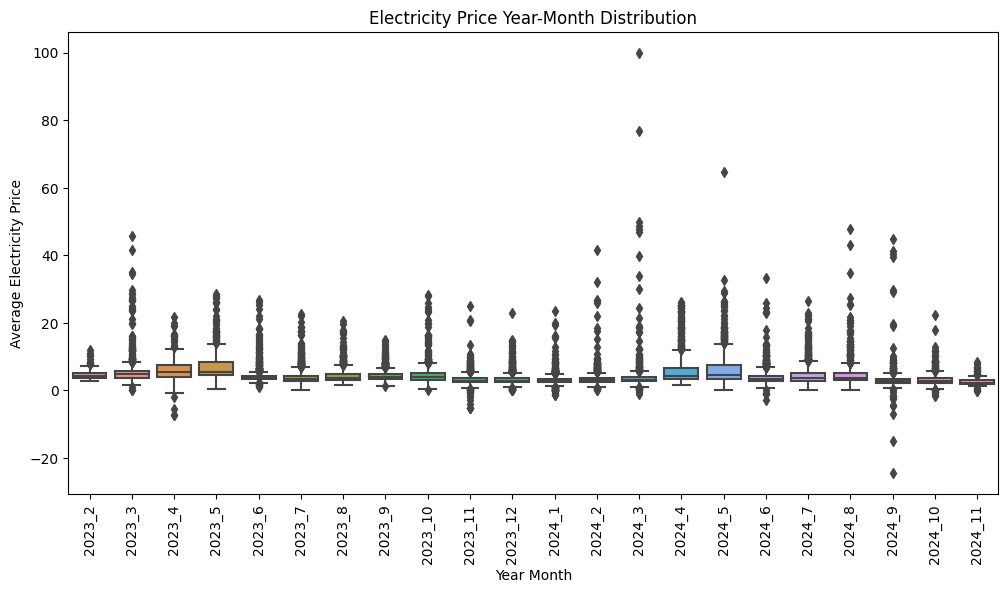

In [243]:
df['Year'] = [x for x in df.index.year]
df['Month'] = [x for x in df.index.month]
df['Year_Month'] = [str(x.year) + '_' + str(x.month) for x in df.index]

df_plot = df[df['Year'] >= 2023].reset_index().sort_values(by='Timestamp').set_index('Timestamp')
plt.figure(figsize=(12, 6))
plt.title(f'Electricity Price Year-Month Distribution')
plt.xticks(rotation=90)
plt.xlabel('Year Month')
plt.ylabel('MW')

sns.boxplot(x='Year_Month', y='Average', data=df_plot)
plt.ylabel('Average Electricity Price')
plt.xlabel('Year Month')

The boxplot of electricity prices across the year and month shows noticeable price increases around the middle of the month, particularly during February, March, April, and May. 
This trend may reflect specific seasonal or operational factors, such as increased demand or scheduled maintenance, that consistently drive prices higher during these periods.

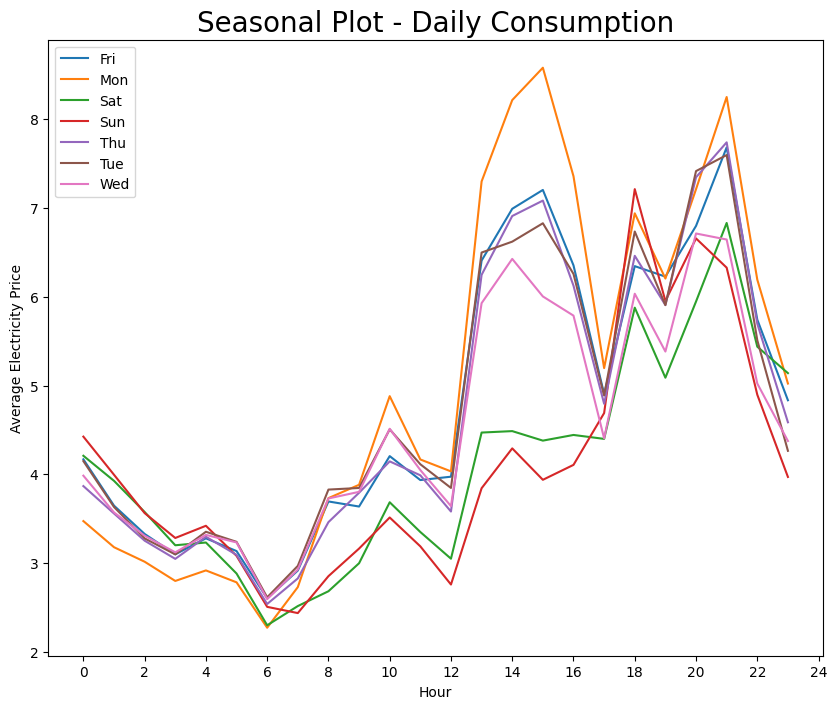

In [244]:
df['day_str'] = [x.strftime('%a') for x in df.index]
df['Hour'] = df.index.hour

# Defining the dataframe
df_plot = df[['Hour', 'day_str', 'Average']].dropna().groupby(['Hour', 'day_str']).mean()[['Average']].reset_index()

# Plot using Seaborn
plt.figure(figsize=(10,8))
sns.lineplot(data = df_plot, x='Hour', y='Average', hue='day_str', legend=True)
plt.locator_params(axis='x', nbins=24)
plt.title("Seasonal Plot - Daily Consumption", fontsize=20)
plt.ylabel('Average Electricity Price')
plt.xlabel('Hour')
plt.legend()

The seasonal plot of daily consumption reveals distinct patterns in electricity prices:

-Peak Hours: Prices are highest during the middle of the day (12:00 to 16:00) and again during the evening hours (19:00 to 21:00), likely due to increased electricity usage during these times.
- Off-Peak Hours: Prices drop significantly during the early morning hours (00:00 to 06:00) when electricity demand is generally low.
This suggests that electricity prices follow a clear diurnal (daily) pattern, correlating strongly with human activity and energy usage patterns.

**VISUALIZE HOURLY ELECTRICITY MARKET PRICE TRENDS**

Text(0, 0.5, 'Average Electricity Price')

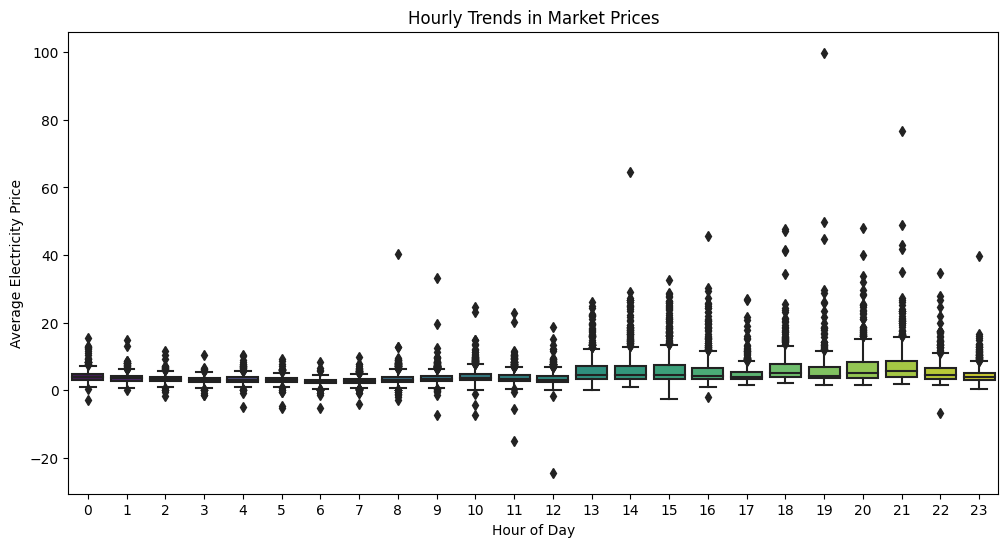

In [245]:
# Hourly Trends Patterns
df['Hour'] = df.index.hour
plt.figure(figsize=(12, 6))
sns.boxplot(x='Hour', y='Average', data=df.reset_index(), palette='viridis')
plt.title('Hourly Trends in Market Prices')
plt.xlabel('Hour of Day')
plt.ylabel('Average Electricity Price')

An analysis of hourly trends indicates:

- Active Hours: Electricity prices are notably active from 08:00 to 23:00, corresponding to the typical hours of economic and residential activity.
- Price Surges: There is a sharp rise in electricity prices between 13:00 and 23:00, with the highest prices observed during these late afternoon and evening hours. 
This might be tied to peak demand as businesses, households, and industries operate at full capacity.

Text(0, 0.5, 'Average Electricity Price')

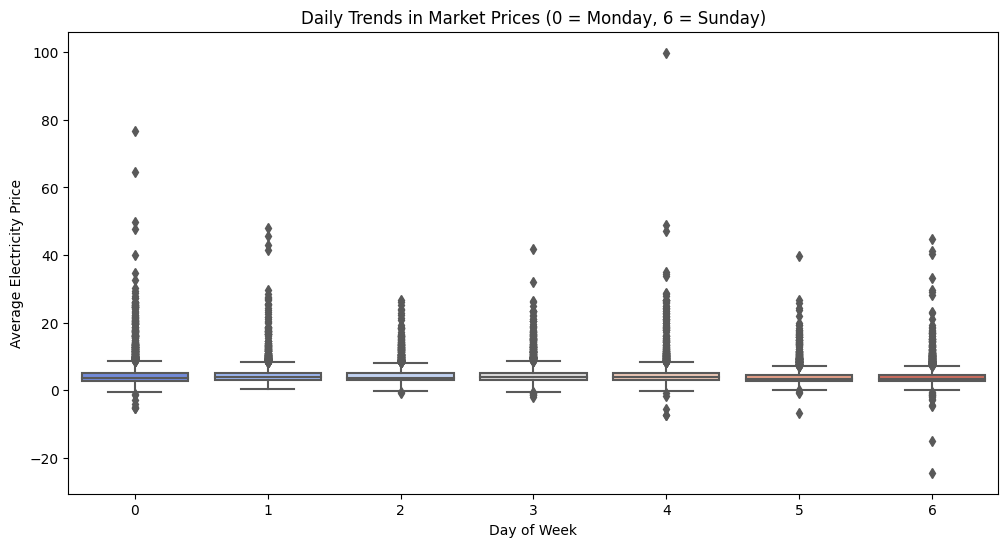

In [246]:
# Day of Week Trends Patterns
df['DayOfWeek'] = df.index.dayofweek
plt.figure(figsize=(12, 6))
sns.boxplot(x='DayOfWeek', y='Average', data=df.reset_index(), palette='coolwarm')
plt.title('Daily Trends in Market Prices (0 = Monday, 6 = Sunday)')
plt.xlabel('Day of Week')
plt.ylabel('Average Electricity Price')

The day-of-week boxplot shows significant variations in electricity prices:

- High Prices on Mondays and Thursdays: These days experience pronounced increases in prices, potentially due to higher demand at the start and midpoint of the workweek.
- Friday Spikes: Electricity prices can reach extreme values, even hitting as high as 99 units. This could reflect a culmination of weekly demand or pre-weekend adjustments in pricing strategies.

Text(0, 0.5, 'Price Variance')

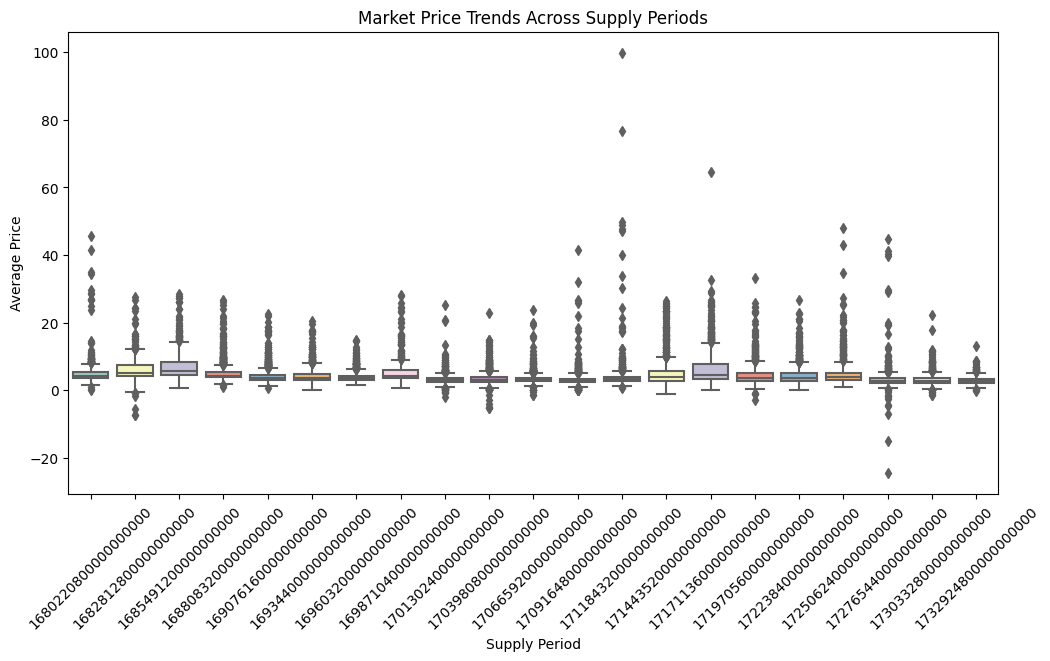

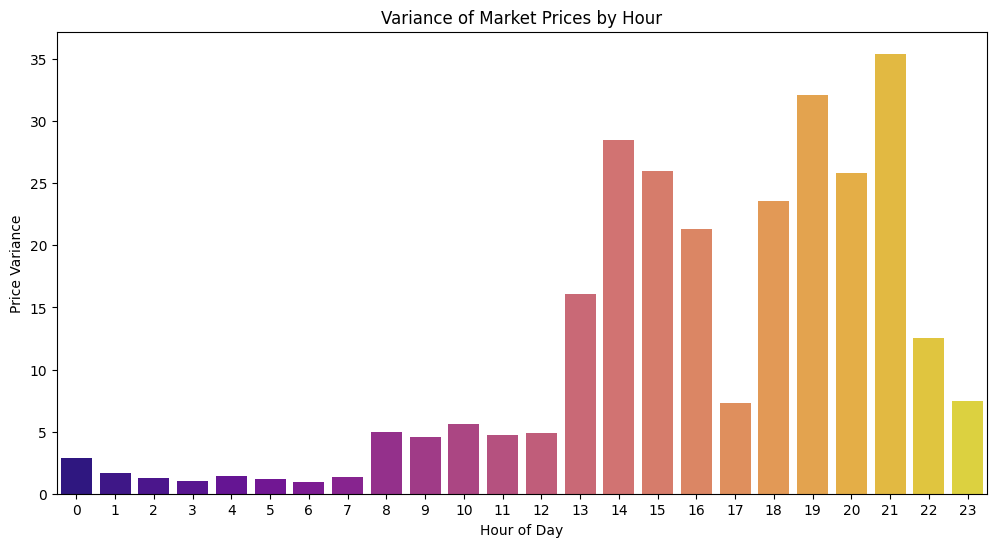

In [247]:

# Monthly Trends Patterns
df['Month'] = df.index.month
monthly_avg = df.groupby('Month')['Average'].mean()

# Price Trends Across Supply Periods
plt.figure(figsize=(12, 6))
sns.boxplot(x='Supply Period', y='Average', data=df.reset_index(), palette='Set3')
plt.title('Market Price Trends Across Supply Periods')
plt.xlabel('Supply Period')
plt.ylabel('Average Price')
plt.xticks(rotation=45)

# Variance of Prices by Hour
hourly_variance = df.groupby('Hour')['Average'].var()

plt.figure(figsize=(12, 6))
sns.barplot(x=hourly_variance.index, y=hourly_variance.values, palette='plasma')
plt.title('Variance of Market Prices by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Price Variance')


Hour with highest average price: 21 (7.30)
Hour with lowest average price: 6 (2.49)


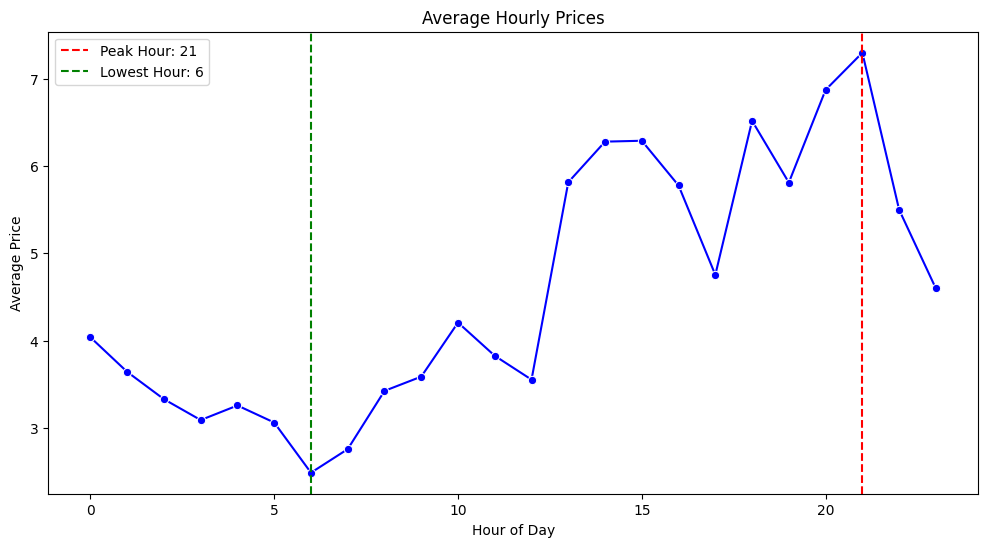

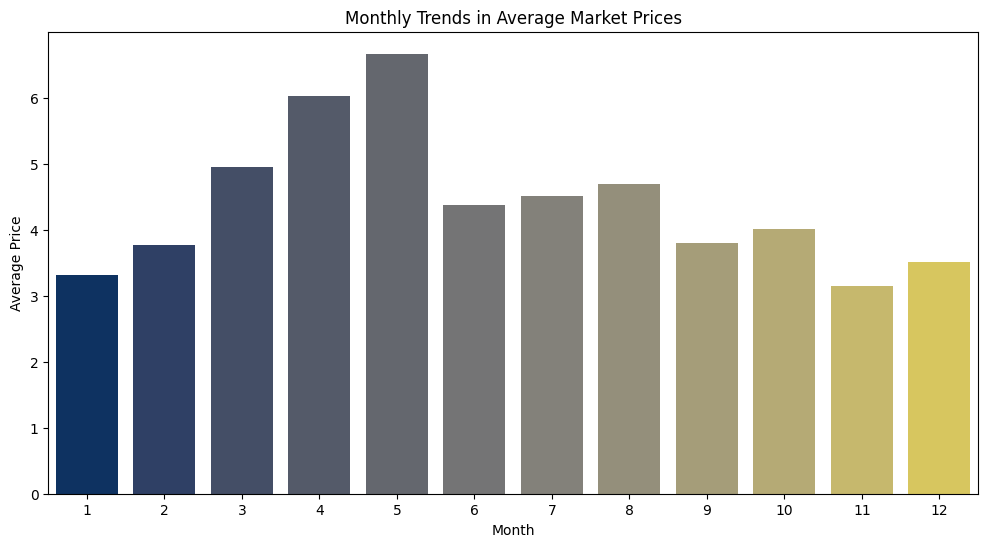

In [248]:
# Find Hours with Peak and Lowest Prices
hourly_avg = df.groupby('Hour')['Average'].mean()
peak_hour = hourly_avg.idxmax()
lowest_hour = hourly_avg.idxmin()

print(f"Hour with highest average price: {peak_hour} ({hourly_avg[peak_hour]:.2f})")
print(f"Hour with lowest average price: {lowest_hour} ({hourly_avg[lowest_hour]:.2f})")

# Plot Average Prices by Hour
plt.figure(figsize=(12, 6))
sns.lineplot(x=hourly_avg.index, y=hourly_avg.values, marker='o', color='b')
plt.title('Average Hourly Prices')
plt.axvline(peak_hour, color='r', linestyle='--', label=f'Peak Hour: {peak_hour}')
plt.axvline(lowest_hour, color='g', linestyle='--', label=f'Lowest Hour: {lowest_hour}')
plt.xlabel('Hour of Day')
plt.ylabel('Average Price')
plt.legend()

plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_avg.index, y=monthly_avg.values, palette='cividis')
plt.title('Monthly Trends in Average Market Prices')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.show()

**Check for Seasonality and Trends in the Time Series**

- Hourly Seasonality: High activity is observed during the afternoon until night, reflecting increased energy demand during these hours.
- Weekly Seasonality: Peak average prices occur on Mondays and weekdays, while weekends show significantly lower market prices.
- Monthly Seasonality: A noticeable surge in market prices is observed during the middle of the month, followed by a downward trend toward the end of the year.

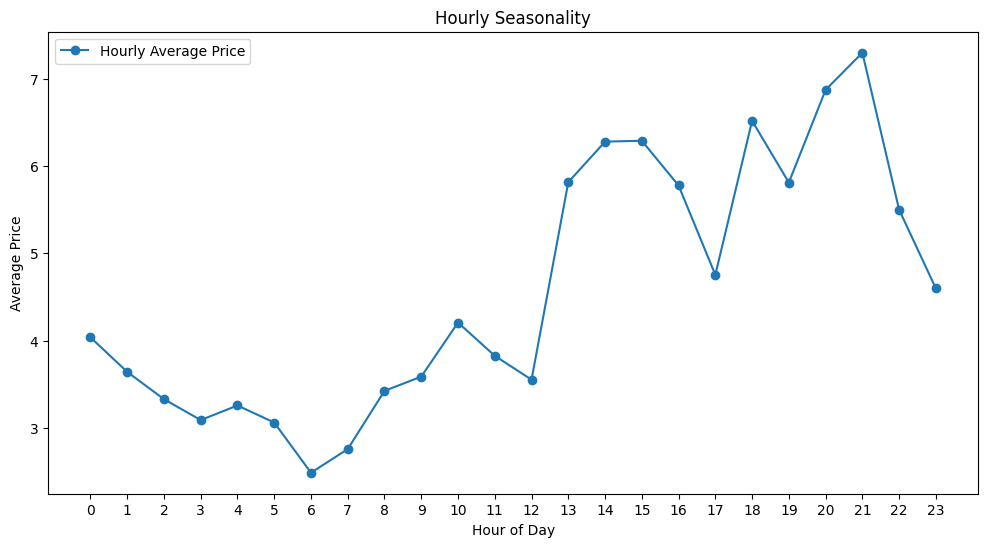

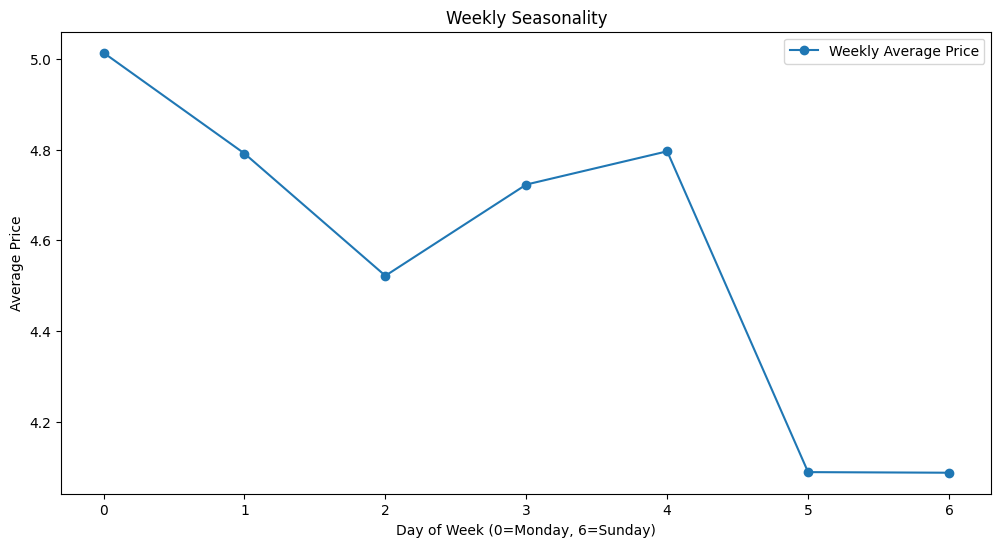

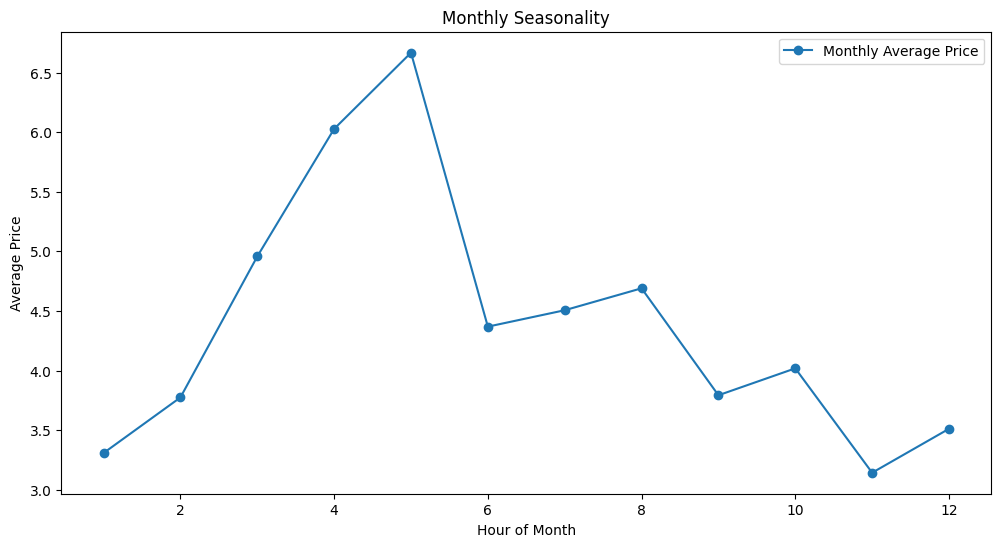

In [249]:
hourly_avg = df.groupby(df.index.hour)['Average'].mean()

plt.figure(figsize=(12, 6))
plt.plot(hourly_avg, marker='o', label='Hourly Average Price')
plt.title('Hourly Seasonality')
plt.xlabel('Hour of Day')
plt.ylabel('Average Price')
plt.xticks(range(24))
plt.legend()

weekly_avg = df.groupby(df.index.dayofweek)['Average'].mean()

plt.figure(figsize=(12, 6))
plt.plot(weekly_avg, marker='o', label='Weekly Average Price')
plt.title('Weekly Seasonality')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Price')
plt.legend()

monthly_avg = df.groupby(df.index.month)['Average'].mean()

plt.figure(figsize=(12, 6))
plt.plot(monthly_avg, marker='o', label='Monthly Average Price')
plt.title('Monthly Seasonality')
plt.xlabel('Hour of Month')
plt.ylabel('Average Price')
plt.legend()

plt.show()

# Time Series Decomposition

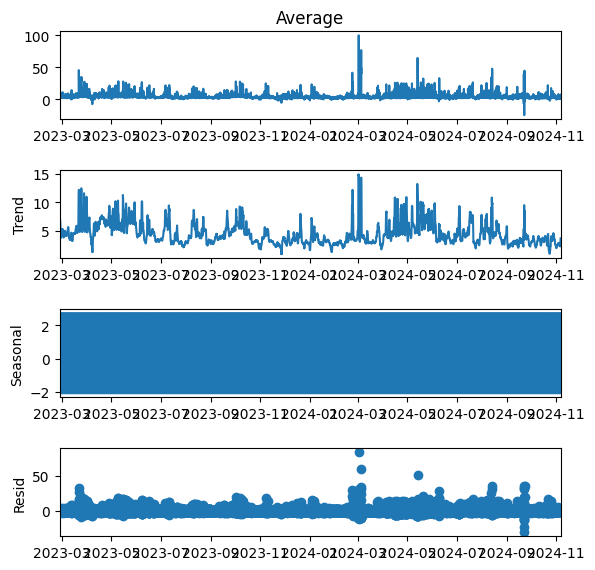

In [250]:
res = seasonal_decompose(df['Average'], model='additive', period=24)
fig = res.plot()
fig.set_size_inches((6, 6))

- The seasonal component appears constant flat, suggesting that the data may lack significant periodicity.
- The residual component shows outliers at certain points, indicating irregular or unexpected events in the data.

2024-10-09 23:00:00


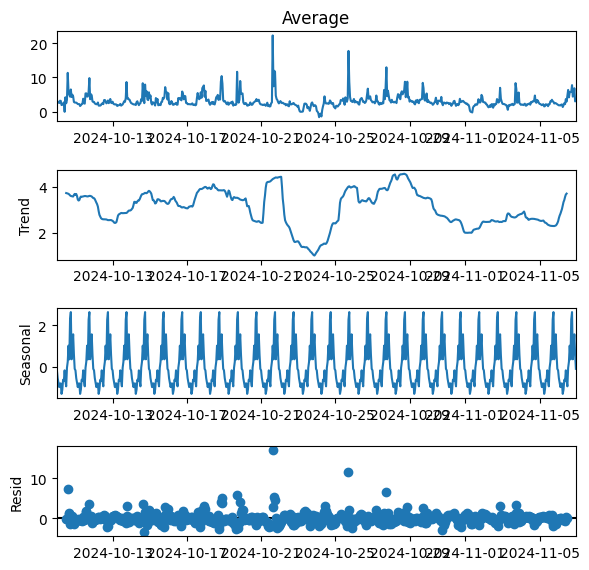

In [251]:
#Checks last 4 weeks of data for decompostion
energy_price = df['Average']
date = energy_price.index[-1] - pd.Timedelta(weeks=4)
print(date)
energy_price = energy_price[energy_price.index > date]
res = seasonal_decompose(energy_price, model='additive')
fig = res.plot()
fig.set_size_inches((6, 6))

When decomposing the data into 4-week intervals, a distinct daily seasonal pattern emerges. This confirms that electricity prices are not only dependent on broader monthly trends but also fluctuate consistently on a daily basis, likely driven by regular usage behaviors and operational cycles.

# Lag Analysis

- Auto-regressive lags: lags close to lag 0, for which we expect high values (recent lags are more likely to predict the present value). They are a representation on how much trend the series shows.
- Seasonal lags: lags referring to seasonal periods. When hourly splitting the data, they usually represent weekly seasonality.

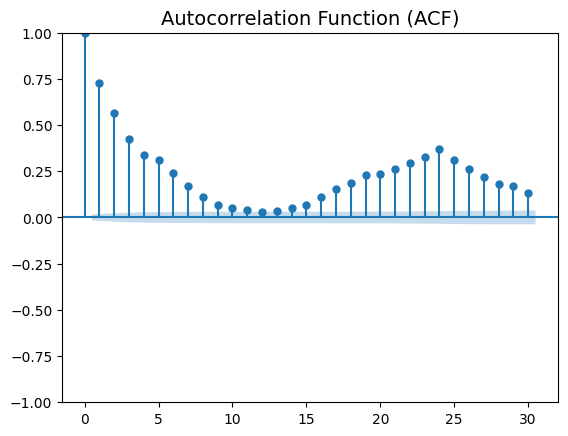

In [252]:
plot_acf(df['Average'], lags=30)
plt.title('Autocorrelation Function (ACF)', fontsize=14)
plt.show()


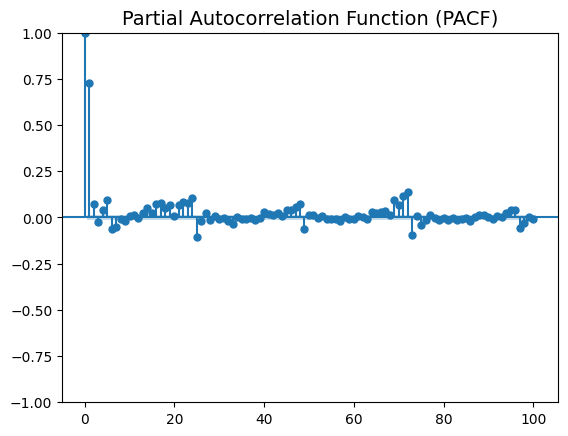

In [253]:
plot_pacf(df['Average'], lags=100, method='ywm')  
plt.title('Partial Autocorrelation Function (PACF)', fontsize=14)
plt.show()


Electricity prices show a strong dependency on:

- Previous Close Price: A clear correlation with lag-1 prices suggests that today's price is heavily influenced by the prior day's closing price.
- Daily Patterns: Prices exhibit repetitive daily behaviors, further reinforcing the significance of consistent consumption and demand cycles.

c:\Users\mlope\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


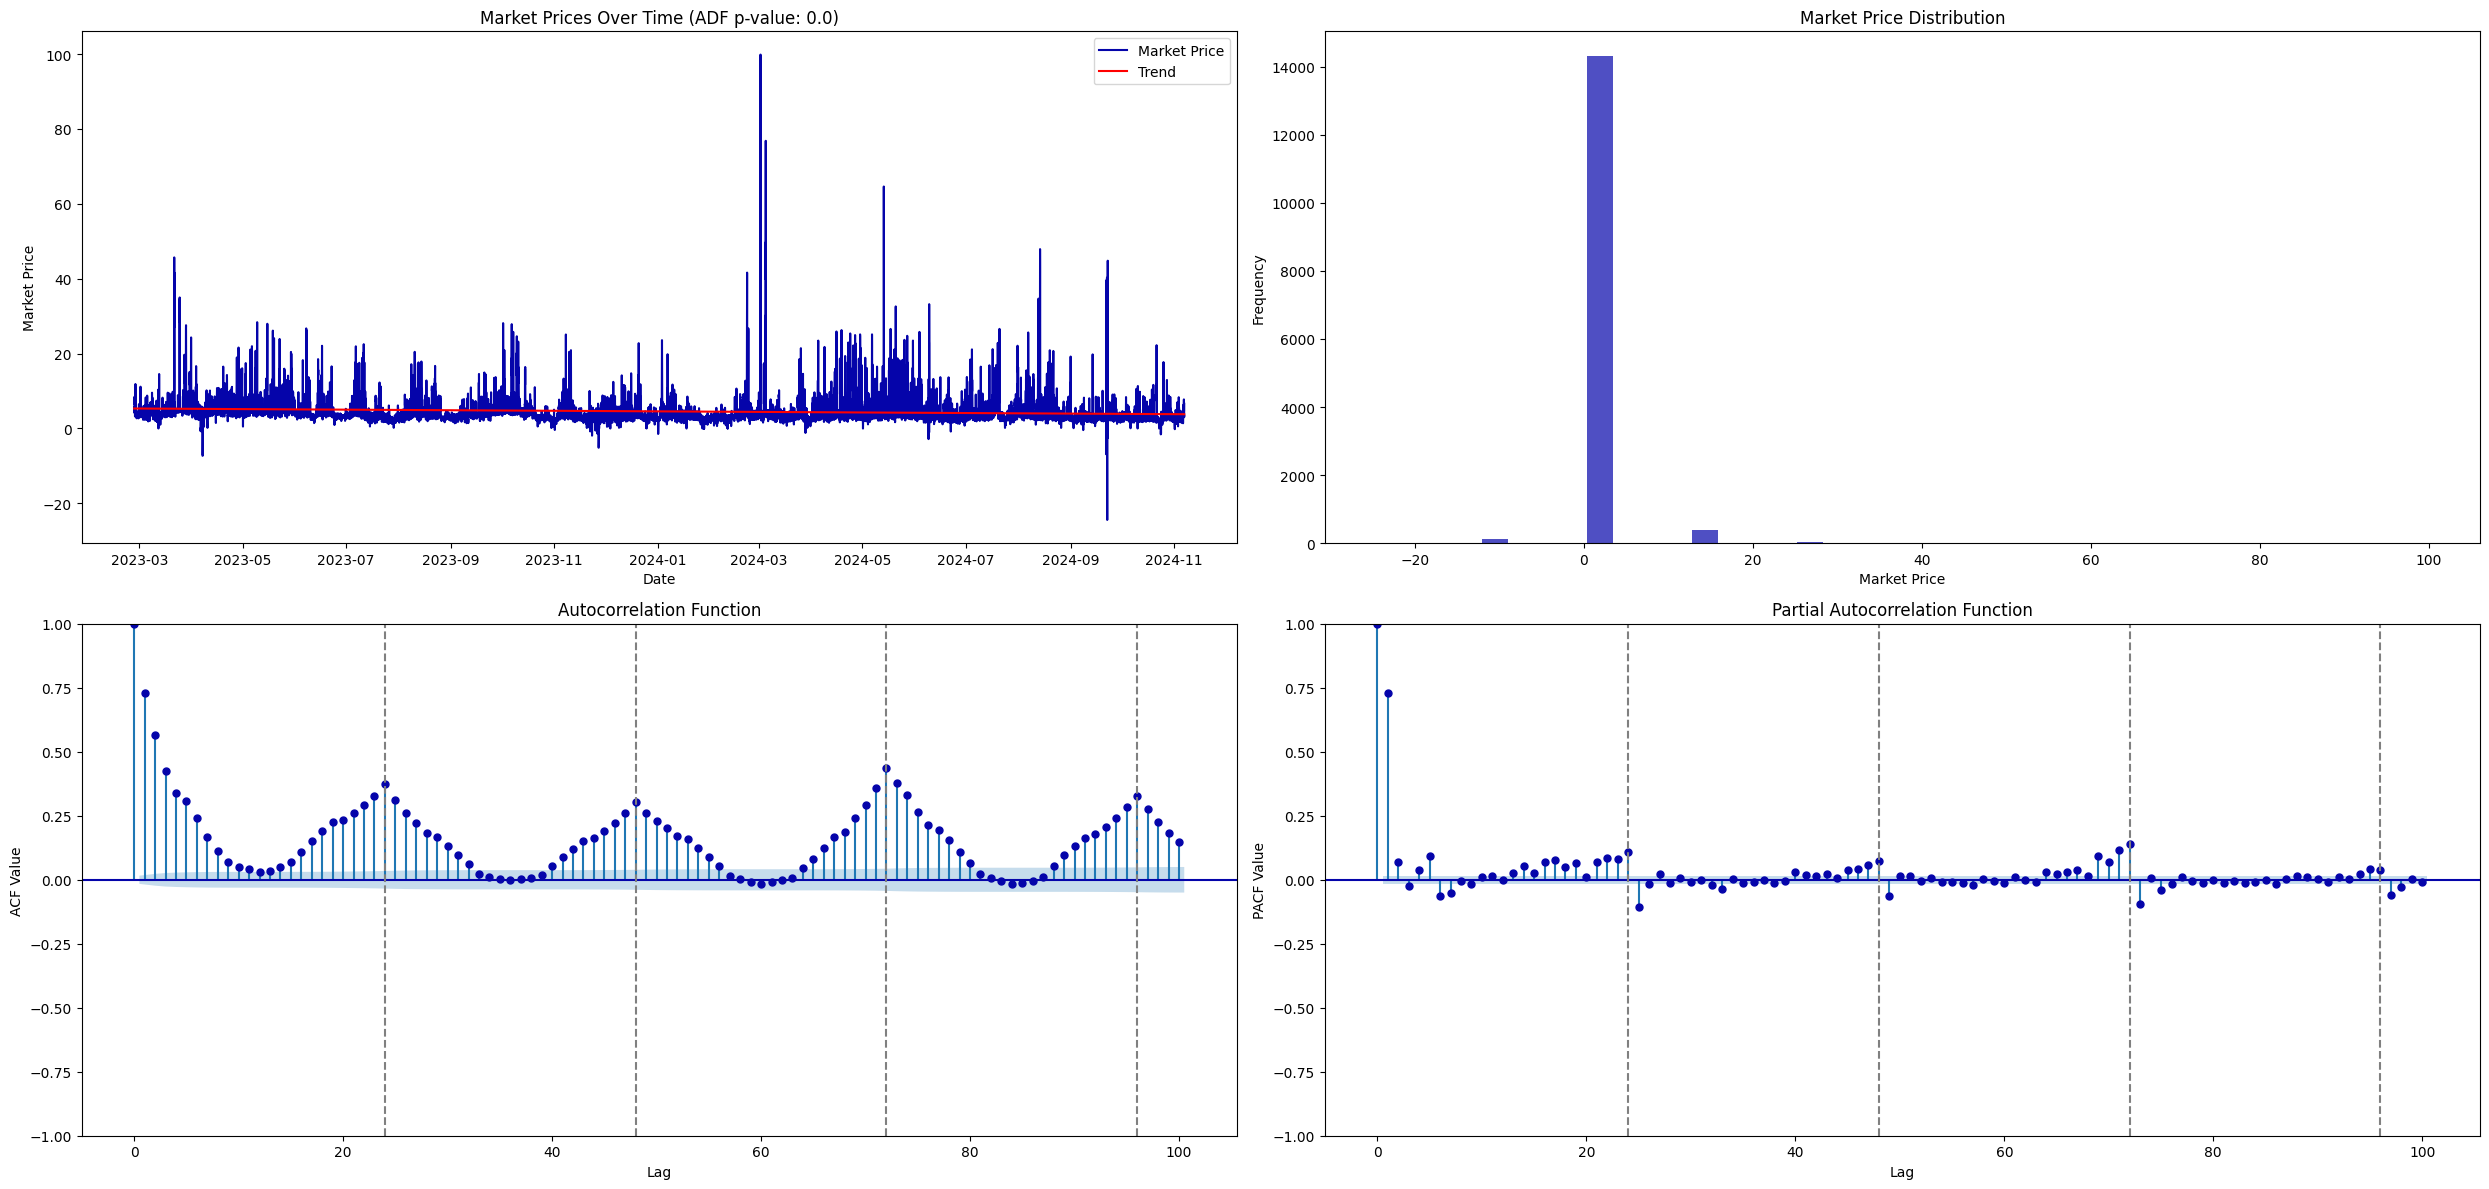

In [254]:
def get_trend(data):
    """
    Get the linear trend from the data, which shows the underlying
    trend component of the time series.
    """
    n = len(data.index)
    X = np.reshape(np.arange(0, n), (n, 1))
    y = np.array(data)
    model = LinearRegression()
    model.fit(X, y)
    trend = model.predict(X)
    return pd.Series(index=data.index, data=trend)

def ts_analysis_plots(data, n_lags=100):
    """
    Perform time-series analysis plots:
    - Original time series with linear trend
    - Histogram of market price distribution
    - Autocorrelation and partial autocorrelation functions
    """
    def plot_cf(ax, fn, data, n_lags):
        """
        Plot autocorrelation functions with emphasis on daily cycles.
        """
        fn(data, ax=ax, lags=n_lags, color="#0504aa")
        for i in range(1, 5):  # Highlight daily cycles (24-hour intervals)
            ax.axvline(x=24 * i, ymin=0.0, ymax=1.0, color='grey', ls="--")

    trend = get_trend(data)
    adf = adfuller(data)

    fig, axs = plt.subplots(2, 2, figsize=(25, 12))
    axs = axs.flat

    axs[0].plot(data, color='#0504aa', label="Market Price")
    axs[0].plot(trend, color="red", label="Trend")
    axs[0].set(xlabel="Date", ylabel="Market Price",
               title=f"Market Prices Over Time (ADF p-value: {round(adf[1], 6)})")
    axs[0].legend()

    axs[1].hist(data, bins=10, width=3, color='#0504aa', alpha=0.7)
    axs[1].set(xlabel="Market Price", ylabel="Frequency",
               title="Market Price Distribution")

    # Autocorrelation
    plot_cf(axs[2], plot_acf, data, n_lags)
    axs[2].set(xlabel="Lag", ylabel="ACF Value", title="Autocorrelation Function")

    # Partial autocorrelation 
    plot_cf(axs[3], plot_pacf, data, n_lags)
    axs[3].set(xlabel="Lag", ylabel="PACF Value", title="Partial Autocorrelation Function")

    plt.tight_layout()
    plt.show()

ts_analysis_plots(df['Average'])

**Conclusion:**
The analysis of electricity prices highlights significant temporal patterns influenced by monthly, daily, and weekly cycles. Prices tend to rise during the middle of certain months, particularly February through May, which could be attributed to seasonal demand or operational factors. Daily consumption patterns reveal peaks during midday (12:00 to 16:00) and evening hours (19:00 to 21:00), with low prices observed during the early morning (00:00 to 06:00). Hourly trends further show that electricity prices are active between 08:00 and 23:00, with the highest surges occurring from 13:00 to 23:00.

Weekly variations indicate substantial price increases on Mondays and Thursdays, while Fridays exhibit extreme spikes, potentially reflecting cumulative demand or pre-weekend adjustments. Moreover, the strong dependency of current prices on the previous day’s closing price and the presence of a consistent daily seasonal pattern emphasize the cyclical nature of electricity prices.

These findings underscore the importance of accounting for both short-term and seasonal patterns in electricity pricing.